Домашнее задание
по теме «ARIMA / SARIMA алгоритмы для сезонных timescale
данных»

In [1]:
import warnings
import seaborn as sns
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd # работа с таблицами
import numpy as np # математические вычисления
from scipy import stats # статистические методы
import matplotlib
import matplotlib.pyplot as plt # визуализация данных

from dateutil.parser import parse # парсер даты

from statsmodels.tsa.seasonal import seasonal_decompose # оценка сезонности
from statsmodels.tsa.ar_model import AutoReg #AR модель
from scipy.stats import normaltest # критерий Д'Агостино K^2, оценка данных на распределение Гаусса
from statsmodels.tsa.statespace.tools import diff  # разность рядов просто и/или сезонно вдоль нулевой оси
from statsmodels.tsa.arima_model import ARMAResults,ARIMAResults # Получить результаты после fit ARMA, ARIMA
from statsmodels.tsa.arima.model import ARIMA # Построить модель ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX # Построить модель SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # plot_acf график автокорреляции, plot_pacf частичной автокорреляции
from statsmodels.graphics.tsaplots import month_plot,quarter_plot # график сезонности данных по месяцам, кварталам
from pandas.plotting import lag_plot # график лага

from statsmodels.tsa.stattools import adfuller # тест Дики-Фуллера

from sklearn.metrics import mean_squared_error # метрика качества MSE
from statsmodels.tools.eval_measures import rmse  # метрика качества Квадратный корень из MSE

from pmdarima import auto_arima # автоматический подбор параметров

In [2]:
plt.rcParams["figure.figsize"] = (10,5) # размер графиков

plt.style.use('fivethirtyeight') # стиль графиков

In [3]:
def adf_test(series,title=''):
  '''
  тест Дики-Фуллера
  0 гипотеза: ряд данных не стационарен
  альтернативная гипотеза: ряд данных стационарен
  Понятие стационарного временного ряда означает, что его среднее значение не изменяется во времени, т. е. временной ряд не имеет тренда
  @param series - значения ряда
  @param title - заголовок ряда
  '''

  result = adfuller(series.dropna(),autolag='AIC') # тест предполагает линейный тренд

  labels = ['ADF тест','p-value','# lags used','# наблюдения']
  out = pd.Series(result[0:4],index=labels)

  for key,val in result[4].items():
      out[f'критическое значение ({key})']=val

  print(out.to_string())

  if result[1] <= 0.05:
      print("Сильные доказательства против нулевой гипотезы")
      print("Отменяем 0 гипотезу")
      print("Данные стационарны")
  else:
      print("Слабые доказательства против нулевой гипотезы")
      print("Не отменяем 0 гипотезу")
      print("Данные не стационарны")

In [ ]:
train_df= pd.read_csv(
    "monthly-beer-production-in-austr.csv",
    index_col="Month", parse_dates= True
    )

train_df.head()

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


In [6]:
train_df.dtypes

,0
Monthly beer production,float64


In [7]:
train_df.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 476 entries, 1956-01-01 to 1995-08-01
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Monthly beer production  476 non-null    float64
dtypes: float64(1)
memory usage: 7.4 KB


In [8]:
# создаем индекс (уникальность) по полю дата
train_df.index= pd.to_datetime(train_df.index)

In [9]:
train_df.index

DatetimeIndex(['1956-01-01', '1956-02-01', '1956-03-01', '1956-04-01',
               '1956-05-01', '1956-06-01', '1956-07-01', '1956-08-01',
               '1956-09-01', '1956-10-01',
               ...
               '1994-11-01', '1994-12-01', '1995-01-01', '1995-02-01',
               '1995-03-01', '1995-04-01', '1995-05-01', '1995-06-01',
               '1995-07-01', '1995-08-01'],
              dtype='datetime64[ns]', name='Month', length=476, freq=None)

Уменишим размер датасета

In [10]:
int_cols = train_df.select_dtypes('int').columns

float_cols = train_df.select_dtypes('float').columns
for col in int_cols:
    train_df[col] = pd.to_numeric(train_df[col], downcast='integer')
for col in float_cols:
    train_df[col] = pd.to_numeric(train_df[col], downcast='float')

In [11]:
train_df.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 476 entries, 1956-01-01 to 1995-08-01
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Monthly beer production  476 non-null    float32
dtypes: float32(1)
memory usage: 5.6 KB


# EDA

In [ ]:
train_df.describe()

,Monthly beer production
count,476.000000
mean,136.395370
std,33.738731
min,64.800003
25%,112.900000
50%,139.150002
75%,158.824997
max,217.800003


In [ ]:
#Подсчитываем сколько процентов незаполнено столбце
percent_missing = train_df.isnull().sum() * 100 / len(train_df.index)
missing_value_df = pd.DataFrame({'Незаполнено столбце %': percent_missing})

missing_value_df

,Незаполнено столбце %
Monthly beer production,0.0


In [ ]:
#Находим медиану
median_df = pd.DataFrame({'Медиана': train_df.median()})

median_df

,Медиана
Monthly beer production,139.149994


In [ ]:
#Находим дисперсию
var_df = pd.DataFrame({'Диспрерсия': train_df.var()})

var_df

,Диспрерсия
Monthly beer production,1138.302002


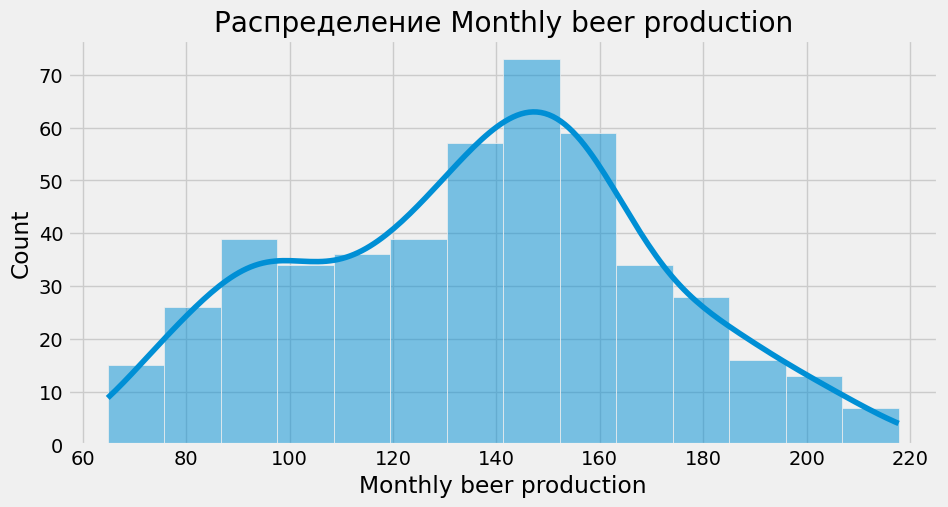

In [ ]:
sns.histplot(train_df['Monthly beer production'], kde=True)
plt.title("Распределение Monthly beer production")
plt.show()

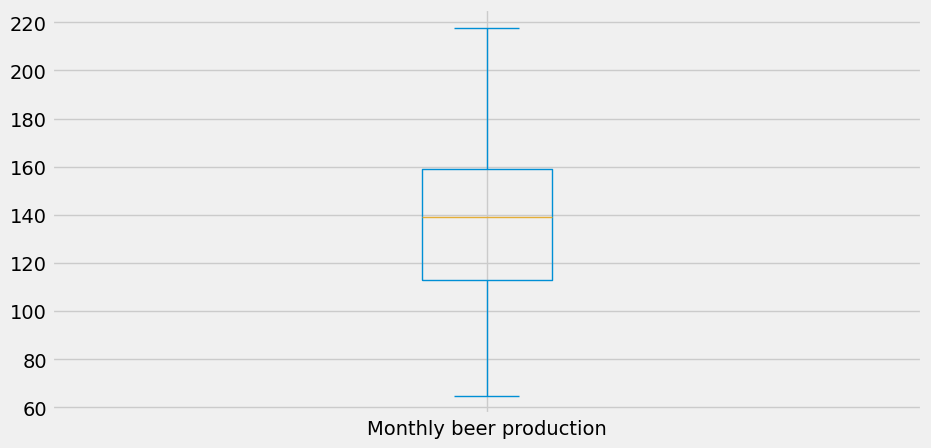

In [ ]:
train_df.plot(
    kind='box',
    subplots=True,
    sharey=False,
)
plt.show()

Нет пропушенных значений в датасете. В данных нет выбросов.

Данные подходят для обучения модели.

# Анализ временного ряда

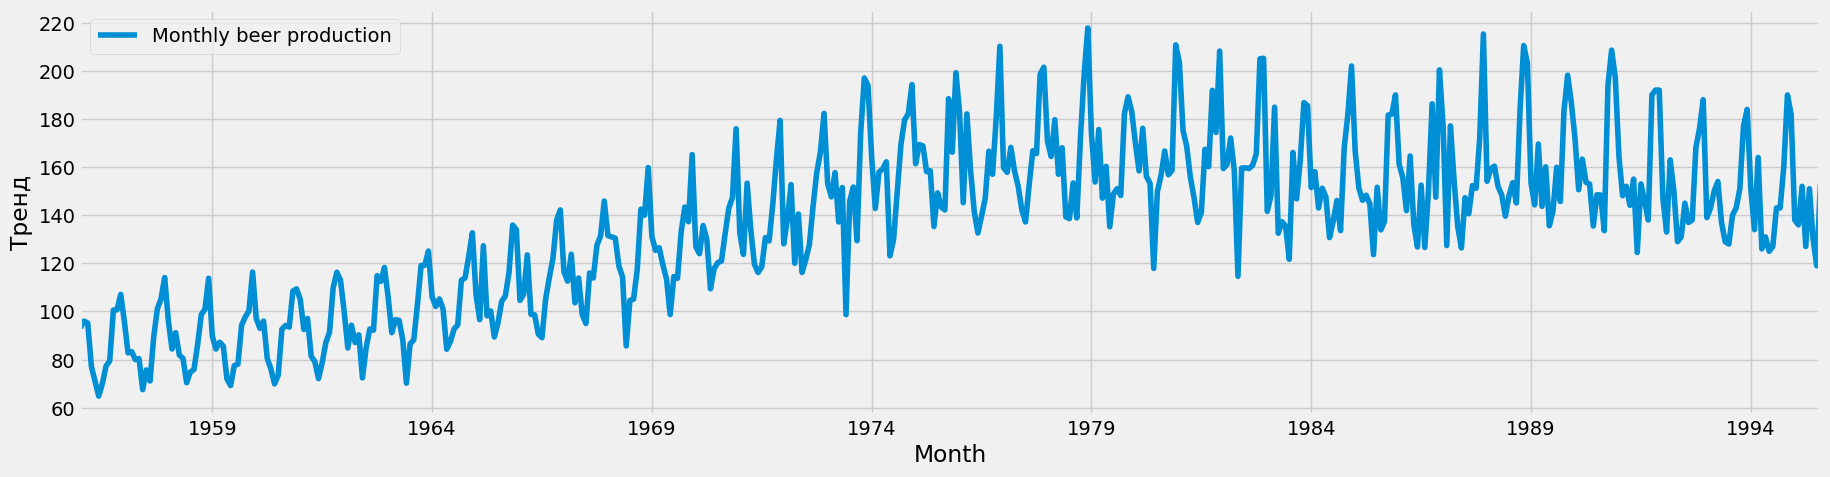

In [15]:
train_df.plot(figsize=(20,5))
plt.ylabel('Тренд')
plt.show()

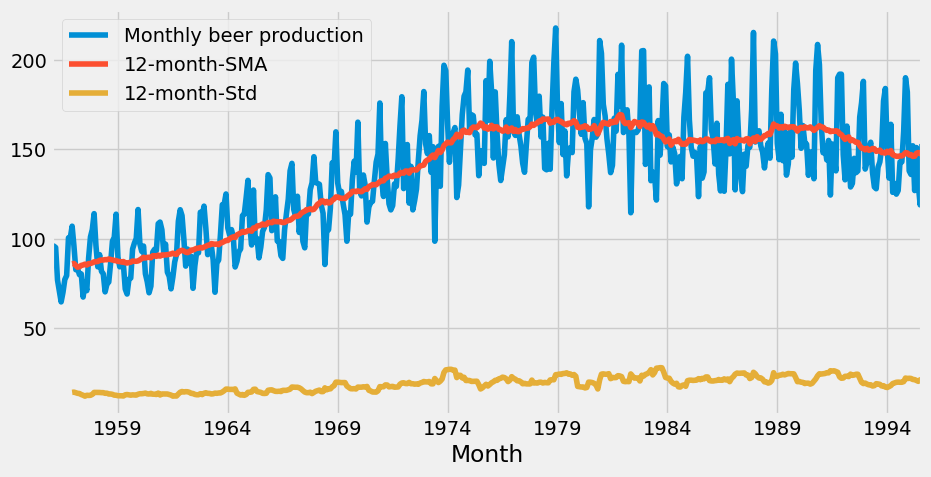

In [ ]:
# дескриптивная аналитики, расчеты скользящего окна
train_df['12-month-SMA'] = train_df['Monthly beer production'].rolling(window=12).mean()
train_df['12-month-Std'] = train_df['Monthly beer production'].rolling(window=12).std()

train_df[['Monthly beer production','12-month-SMA','12-month-Std']].plot();

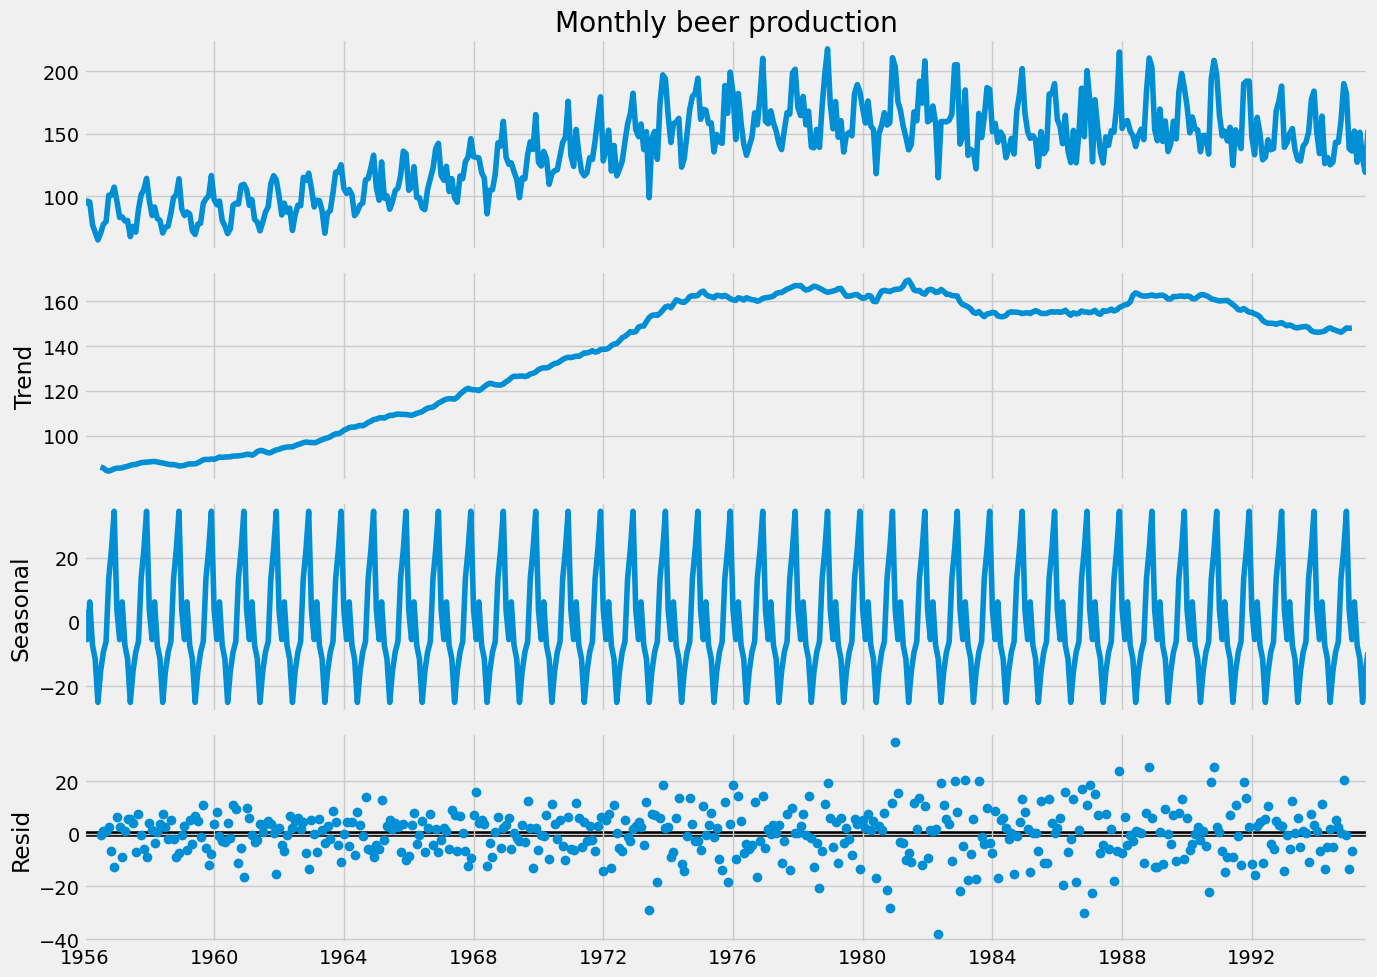

In [ ]:
# сезонная декомпозиция
ssn= seasonal_decompose(train_df["Monthly beer production"], model="add")
fig = ssn.plot()
fig.set_size_inches((14, 10))
fig.tight_layout()
plt.show()

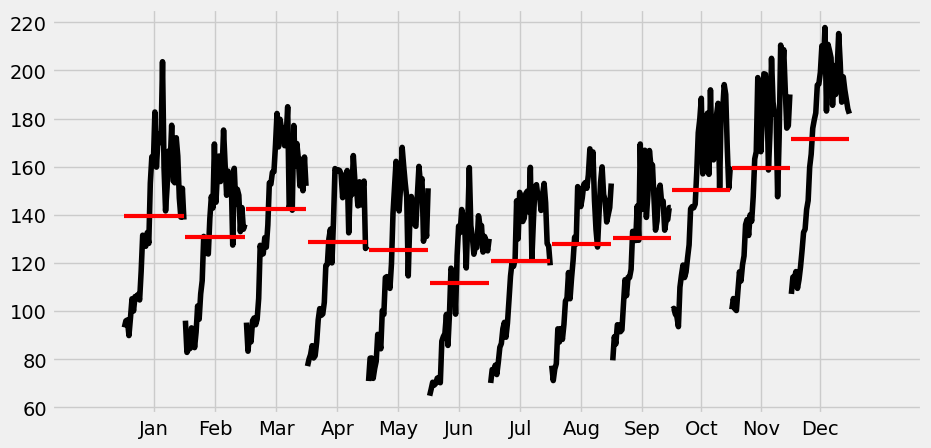

In [ ]:
# построим новый вид графика
month_plot(train_df['Monthly beer production']);

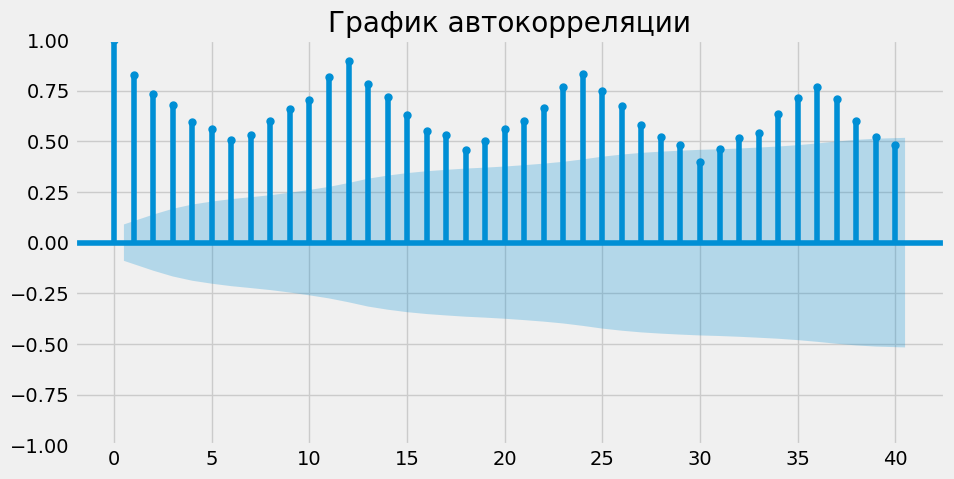

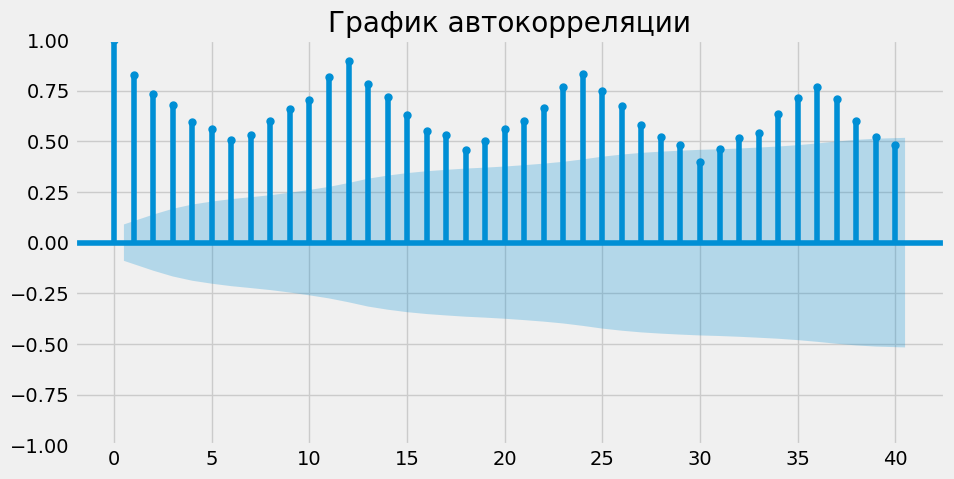

In [ ]:
# ACF
title = 'График автокорреляции'
lags = 40 # оптимальное значение (т.к. большой времнной период)
plot_acf(train_df["Monthly beer production"],title=title,lags=lags)

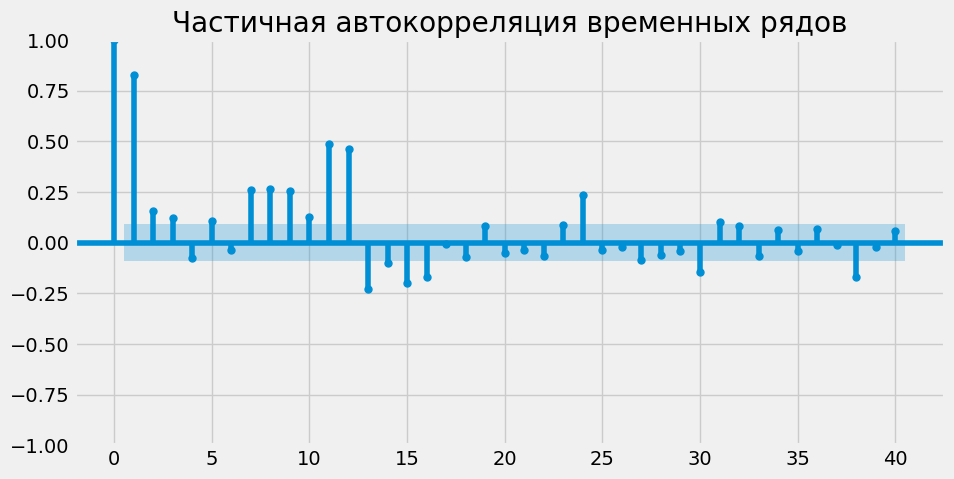

In [ ]:
# PACF - функция частичной автокорреляции дает частичную корреляцию стационарного временного ряда с его собственными запаздывающими значениями
title = 'Частичная автокорреляция временных рядов'
lags = 40
plot_pacf(train_df["Monthly beer production"],title=title,lags=lags);

С начала 1960-х кол-во производимого пива в год постепенно увеличивалось, а в 1980-х остановилось и оставалось примерно одинаковым.

Изменение кол-ва производимого пива связано с временем года. Зимой производится больше всего пива, а летом - меньше всего. График автокорреляции поддерживает этот вывод.

PACF тоже указывает на годовую зависимость данных. Пики на 12 (декабрь) лагах, и минимумы на 6 (июнь).

# Cтационарность

In [17]:
# тест на стационарность, p-value < 0.05
adf_test(train_df["Monthly beer production"])

ADF тест                       -2.282661
p-value                         0.177621
# lags used                    17.000000
# наблюдения                  458.000000
критическое значение (1%)      -3.444709
критическое значение (5%)      -2.867871
критическое значение (10%)     -2.570142
Слабые доказательства против нулевой гипотезы
Не отменяем 0 гипотезу
Данные не стационарны


Данные не стационарны

# Разделим на тестовый и тренировочный набор данных

In [18]:
# разделим на тестовый и тренировочный набор данных
TEST_SIZE = 12
train= train_df.iloc[:len(train_df)-TEST_SIZE]
test= train_df.iloc[len(train_df)-TEST_SIZE:]

## ARIMA

In [31]:
# найдем порядок p,d,q
# ARIMA: обучение модели без сезонной составляющей
auto_arima_results= auto_arima(train["Monthly beer production"],
           start_p=0,
           start_q=0,
           max_p=5,
           max_q=5,
           m=12,
           d=None,
           seasonal=False,
           start_P=0,
           D=0,
           trace=True,
           error_action='ignore',
           stepwise=True)

auto_arima_results.summary()

/usr/local/lib/python3.11/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4070.292, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4047.060, Time=0.37 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4037.367, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4068.306, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3957.114, Time=1.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4028.080, Time=1.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4013.977, Time=2.94 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3968.833, Time=0.63 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4035.182, Time=0.36 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3952.461, Time=0.58 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3953.392, Time=0.62 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3954.005, Time=0.74 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3960.438, Time=0.57 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3958.799, Time=0.65 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  464
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1970.230
Date:                Mon, 31 Mar 2025   AIC                           3952.461
Time:                        19:47:34   BIC                           3977.287
Sample:                    01-01-1956   HQIC                          3962.234
                         - 08-01-1994                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1431      0.076      1.884      0.060      -0.006       0.292
ar.L1         -0.3161      0.101     -3.126      0.002      -0.514      -0.118
ar.L2          0.3261      0.075      4.362      0.000       0.180       0.473
ma.L1         -0.1055      0.082     -1.287      0.198      -0.266       0.055
ma.L2         -0.8085      0.082     -9.887      0.000      -0.969      -0.648
sigma2       289.8766     18.516     15.655      0.000     253.586     326.168
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 2.37
Prob(Q):                              0.75   Prob(JB):                         0.31
Heteroskedasticity (H):               3.33   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

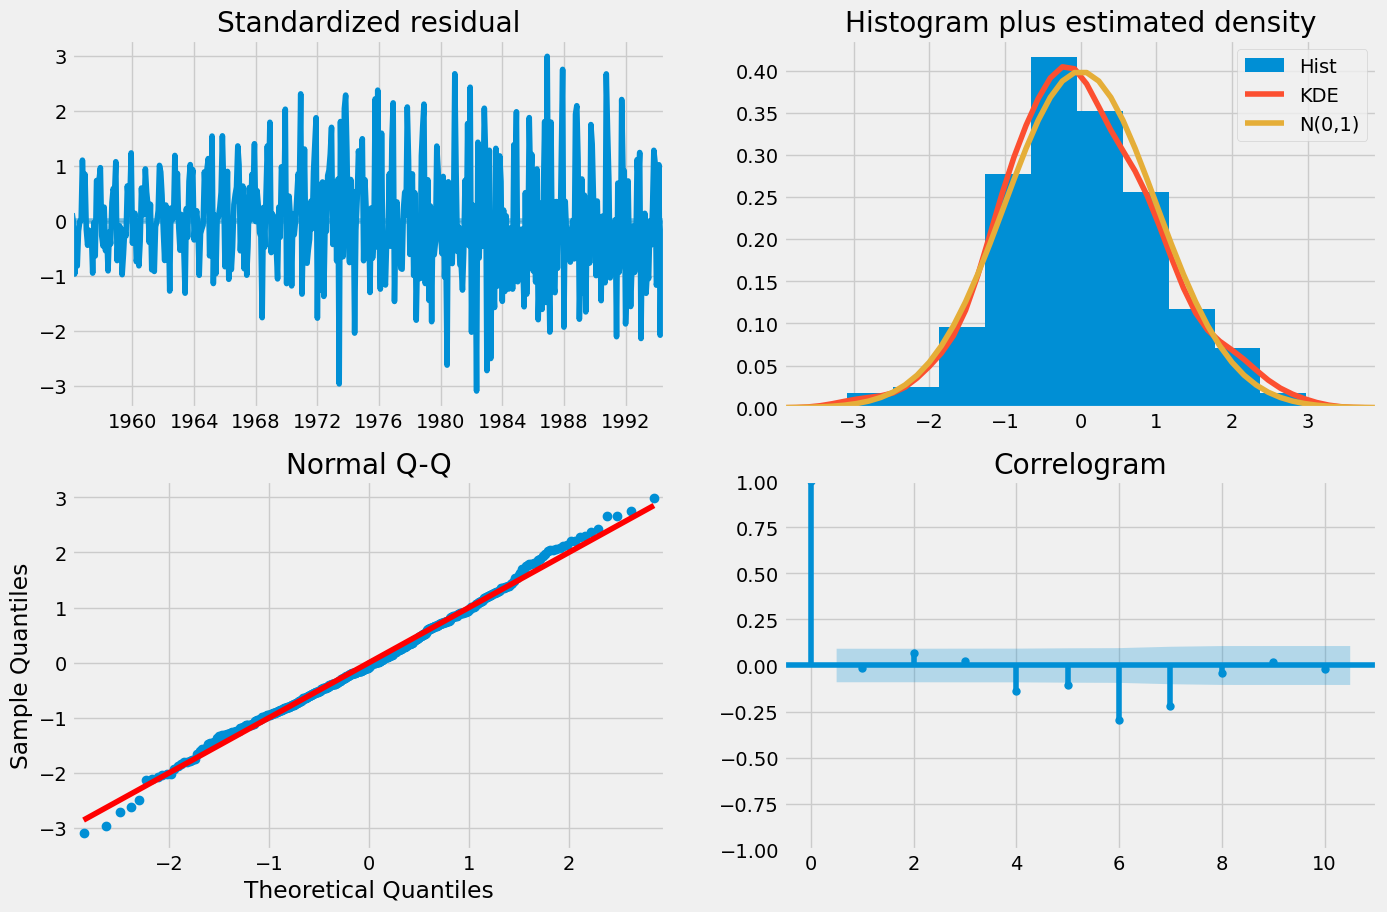

In [26]:
# интерпретация ARIMA модели в виде графиков
auto_arima_results.plot_diagnostics(figsize=(15,10))
plt.show()

In [27]:
# обучим модель ARIMA используя p,d,q из полученного результата по auto_arima
arima_model= ARIMA(train["Monthly beer production"], order= (2,1,2), freq=train.index.inferred_freq)
arima_model_fit= arima_model.fit()

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [28]:
normaltest(arima_model_fit.resid)
# если p-value не менее 0.05 , это означает, что остатки нормально распределены

NormaltestResult(statistic=np.float64(30.04463277675253), pvalue=np.float64(2.9915129494361033e-07))

In [40]:
# сделаем прогноз на test наборе данных
start= len(train)
end= len(train) + len(test) -1

pred_arima= arima_model_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("ARIMA predictions")

<Axes: title={'center': 'Актуальность и Прогноз для Test набора данных'}, xlabel='Month'>

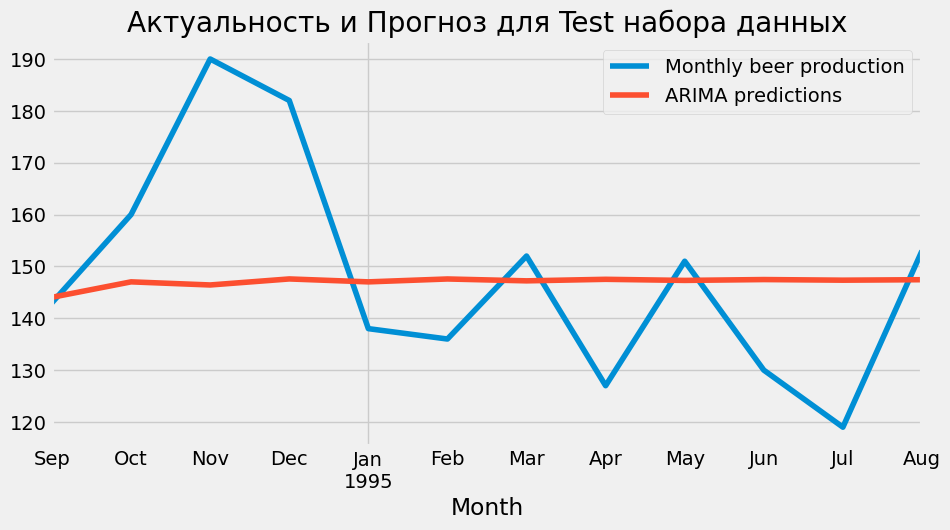

In [41]:
title= "Актуальность и Прогноз для Test набора данных"
test["Monthly beer production"].plot(title= title, legend=True);
pred_arima.plot(legend=True)

## Оценка модели

In [47]:
# оценим модель по штрафным баллам
mse= mean_squared_error(test["Monthly beer production"],pred_arima)
rmse_arima= rmse(test["Monthly beer production"], pred_arima)

print(f"RMSE= {rmse_arima} \n")
print(f"MSE= {mse}")

err_df = {}
err_df['ARIMA'] = {'RMSE': rmse_arima, 'MSE': mse}

RMSE= 20.54512007411772 

MSE= 422.1019588599149


## SARIMA

In [32]:
# найдем порядок p,d,q, сезонность P, D, Q
# ARIMA: обучение модели с сезонной составляющей
smodel = auto_arima(train["Monthly beer production"],
                    start_p=0,
                    start_q=0,
                    max_p=3,
                    max_q=3,
                    m=12,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=3965.594, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4070.292, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3807.869, Time=1.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3839.739, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4068.306, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4047.060, Time=0.13 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3784.077, Time=1.62 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=3.07 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3689.062, Time=1.48 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3911.395, Time=1.74 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=3.00 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3852.962, Time=1.62 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=5.29 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  464
Model:             SARIMAX(2, 1, 3)x(1, 0, [1], 12)   Log Likelihood               -1695.111
Date:                              Mon, 31 Mar 2025   AIC                           3406.223
Time:                                      19:54:02   BIC                           3439.325
Sample:                                  01-01-1956   HQIC                          3419.254
                                       - 08-01-1994                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1500      0.004   -275.895      0.000      -1.158      -1.142
ar.L2         -0.9932      0.005   -214.797      0.000      -1.002      -0.984
ma.L1          0.2362      0.025      9.591      0.000       0.188       0.284
ma.L2         -0.0040      0.025     -0.162      0.871      -0.052       0.044
ma.L3         -0.8616      0.023    -37.805      0.000      -0.906      -0.817
ar.S.L12       0.9951      0.004    239.788      0.000       0.987       1.003
ma.S.L12      -0.8072      0.034    -23.828      0.000      -0.874      -0.741
sigma2        80.9259      4.364     18.543      0.000      72.372      89.479
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):                35.97
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               3.93   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
# обучим модель
sarima_model= SARIMAX(train["Monthly beer production"], order= (2,1,3), seasonal_order= (1,0,1,12), freq=train.index.inferred_freq)
sarima_model_fit= sarima_model.fit()

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [42]:
# сделаем прогнозы на Test данных
start= len(train)
end= len(train) + len(test) -1
pred_sarima= sarima_model_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("SARIMA predictions")

<Axes: title={'center': 'Актуальность и прогноз для Test данных'}, xlabel='Month'>

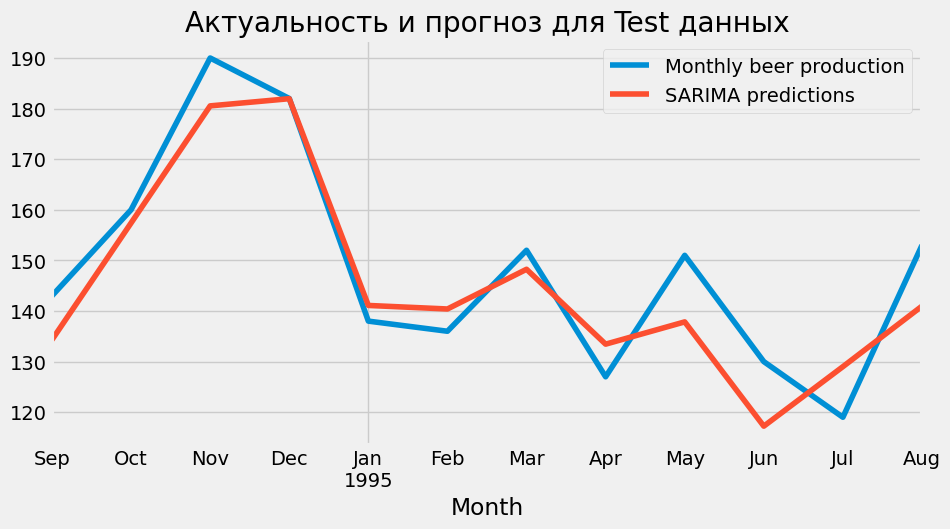

In [43]:
# построим прогноз
title= "Актуальность и прогноз для Test данных"
test["Monthly beer production"].plot(title= title, legend=True)
pred_sarima.plot(legend=True)

## Оценка модели

In [48]:
# оценим модель
mse= mean_squared_error(test["Monthly beer production"],pred_sarima)
rmse_sarima= rmse(test["Monthly beer production"], pred_sarima)

print(f"RMSE= {rmse_sarima} \n")
print(f"MSE= {mse}")

err_df['SARIMA'] = {'RMSE': rmse_sarima, 'MSE': mse}

RMSE= 8.351898495508687 

MSE= 69.75420847928025


## Вывод

In [49]:
err_df = pd.DataFrame(err_df)
err_df

,ARIMA,SARIMA
RMSE,20.545120,8.351898
MSE,422.101959,69.754208


<Axes: title={'center': 'Актуальность и прогноз для Test данных'}, xlabel='Month'>

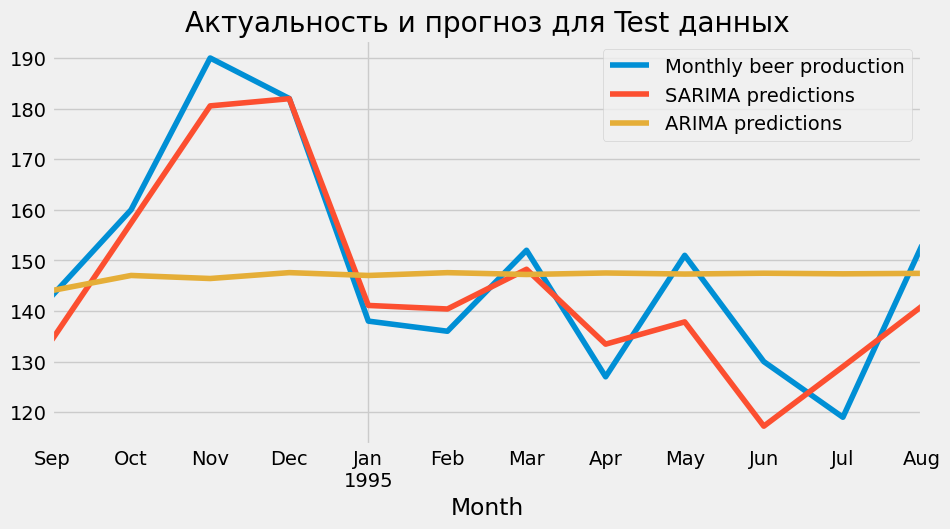

In [44]:
# построим прогноз
title= "Актуальность и прогноз для Test данных"
test["Monthly beer production"].plot(title= title, legend=True)
pred_sarima.plot(legend=True)
pred_arima.plot(legend=True)

Из графиков и оценок RMSE и MSE можно сделать вывод, что модель SARIMA лучше прогнозировала данные датасета.